In [1]:
import pandas as pd

# Hardcoded file path
filename = "population2.5.csv.gz"

# Read and print the table
df = pd.read_csv(filename, compression='gzip')
df["notch_amplitude"] = df["notch_amplitude"].astype(float) 
df["notch_lowmass_exponent"] = df["notch_lowmass_exponent"].astype(float) 
df.head()["notch_amplitude"]


0   -10.0
1   -10.0
2   -10.0
3   -10.0
4   -10.0
Name: notch_amplitude, dtype: float64

In [2]:
converted_posterior_samples = df.to_dict(orient="list")
# read ../conversion_dictionaries/multiPDB_betaSplit_brokenG.txt as dict file 
import ast
import numpy as np
with open("../conversion_dictionaries/multiPDB_betaSplit_brokenG.txt", "r") as f:
    conversion_dict = ast.literal_eval(f.read())

samples = []
num_hyperparams = len(conversion_dict)
num_samples = len(converted_posterior_samples["notch_amplitude"])

for i in range(num_samples):
    sample_dict = {}
    for key, value in converted_posterior_samples.items():
        sample_dict[key] = value[i]
    samples.append(sample_dict)
assert len(samples) == num_samples, f"Expected 5000 samples, but got {len(samples)}"
assert len(samples[0]) == num_hyperparams, f"Expected each dictionary to have {num_hyperparams} keys, but got {len(samples[0])}"


In [3]:
from gwdistributions import parse, generators
import matplotlib.pyplot as plt
from tqdm import tqdm

EG = generators.EventGenerator(*parse.parse_config("multiPDB_betaSplit_brokenG.ini"))
mass_dist2d = EG.variate2distribution("mass1_source")
mass_dist1d = mass_dist2d.massdist

p_m_arr = np.zeros((200, 1000))

for i, s in tqdm(enumerate(samples[:200]), total=200):
    EG.update(**s)
    mass_grid = np.logspace(0, 1.999, 1000)
    p_m = mass_dist1d.prob(mass_grid)
    p_m_arr[i] = p_m

/fs/lustre/scratch/mali/.venv/lib64/python3.11/site-packages/gwdistributions/distributions/location/angles/zodiac/iau.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/fs/lustre/scratch/mali/.venv/lib64/python3.11/site-packages/gwdistributions/utils/cosmology.py:178: RuntimeWarning: divide by zero encountered in log
  return be.log(4*be.pi) + 2*be.log(Dc) + be.log(self.dDcdz(z))
  0%|          | 0/200 [00:00<?, ?it/s]/fs/lustre/scratch/mali/.venv/lib64/python3.11/site-packages/gwdistributions/distributions/base/filter.py:272: RuntimeWarning: overflow encountered in power
  return -be.log(1 + (val/scale)**exp)
100%|██████████| 200/200 [00:16<00:00, 12.46it/s]


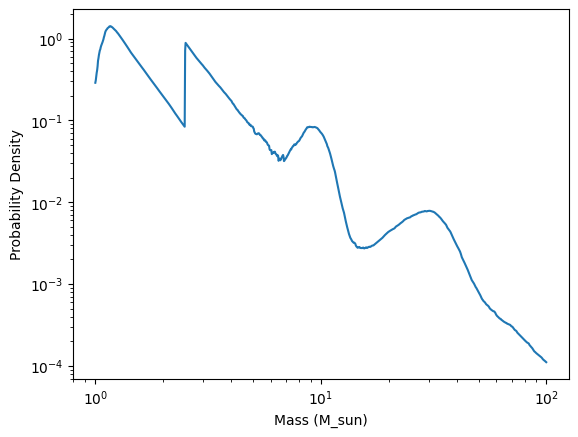

In [4]:
p_m50 = np.median(p_m_arr, axis=0)
plt.plot(mass_grid, p_m50)
plt.xscale("log")
plt.xlabel("Mass (M_sun)")
plt.ylabel("Probability Density")
plt.yscale("log")